In [2]:
%pip install torch torchvision transformers diffusers datasets accelerate
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),  # Flatten the output
    torch.nn.Linear(768, 256),  # Adjust the input features to match flattened output
    torch.nn.ReLU(),
    #torch.nn.functional.Normalize(),  # Batch normalization layer
    #torch.nn.BatchNorm1d(256),
    torch.nn.LayerNorm(256),
    torch.nn.Linear(256, 1),
    torch.nn.Hardtanh()
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
teacher_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",safety_checker=None, torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)
#teacher_model.safety_checker = lambda image : False

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",safety_checker=None, torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [7]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [10]:
# Set up the loss functions for the student model

def adversarial_loss_function(y_pred, y_true):
    return torch.nn.functional.relu(1 - y_pred * y_true)

def student_loss_function(y_pred, y_true):
    return - y_pred * y_true

# # Hinge loss for adversarial loss
# adversarial_loss_function.requires_gradient = True

# MSE loss for distillation loss
distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.0001)

# Assuming you have a discriminator model defined
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0001)

In [11]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/dataset.json')

train_dataset = dataset["train"]

#split the dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)


Dataset({
    features: ['image', 'caption'],
    num_rows: 239659
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 29588
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 26629
})


In [12]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 256, 256])


In [13]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

Epoch 0, Batch Caption: Two surfers are catching some waves of the ocean.


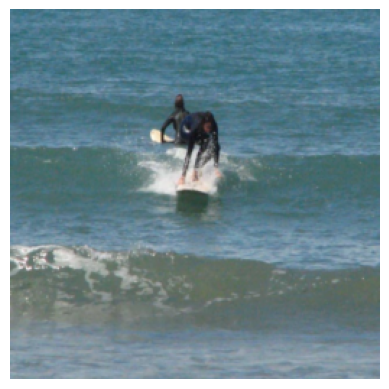

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

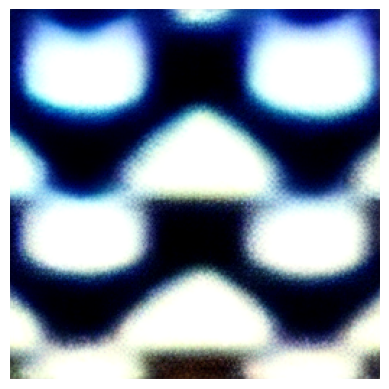

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

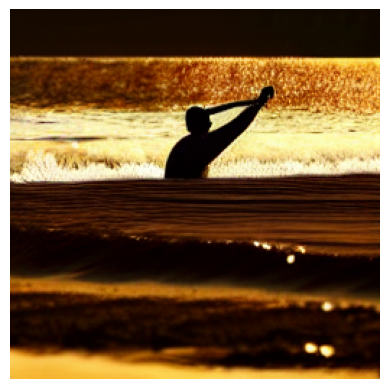

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.39950263500213623
End of batch processing.

Epoch 0, Batch Caption: A kitchen scene with focus on a kitchen cabinet.


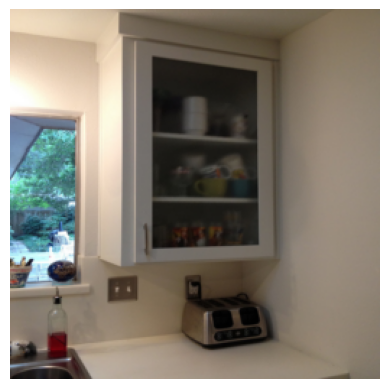

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

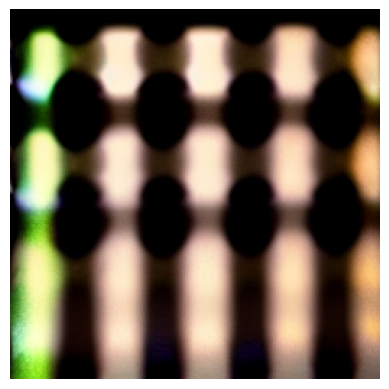

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

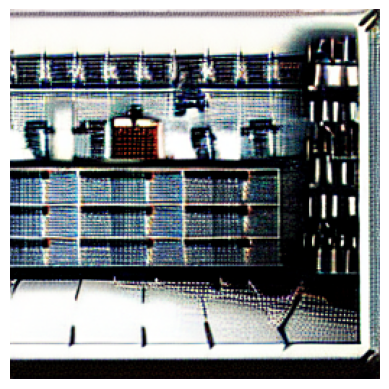

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.2971702516078949
End of batch processing.

Epoch 0, Batch Caption: This is a photo of a bathroom in someones home.


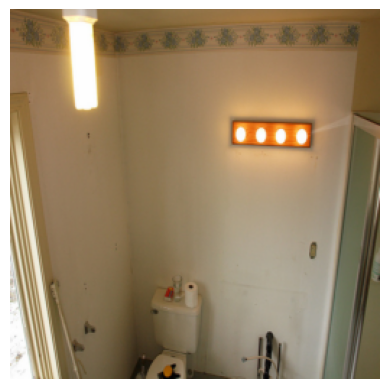

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

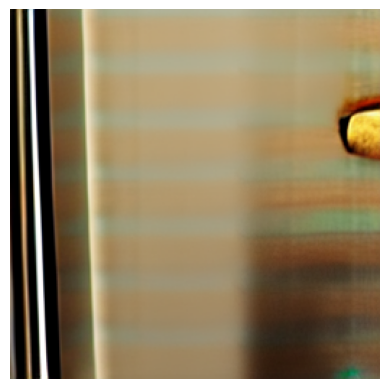

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

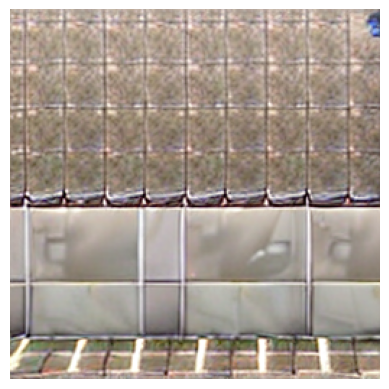

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.07866781949996948
End of batch processing.

Epoch 0, Batch Caption: A commuter bus in Miami with bicycles on its front rack


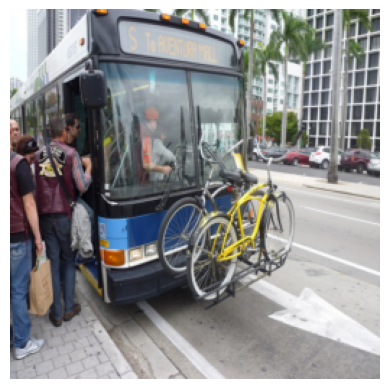

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

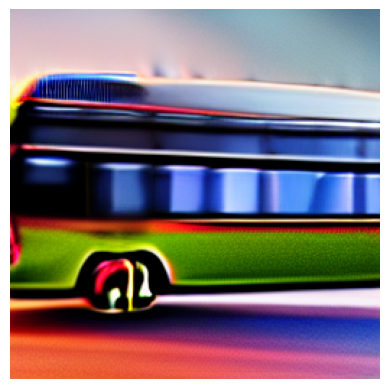

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

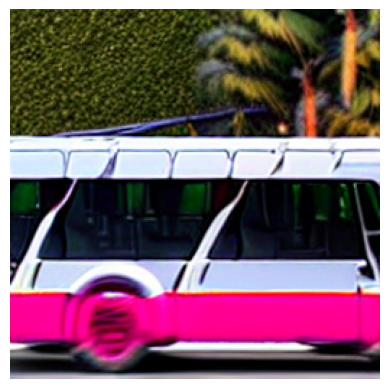

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.26975885033607483
End of batch processing.

Epoch 0, Batch Caption: several police officers riding on horses through town


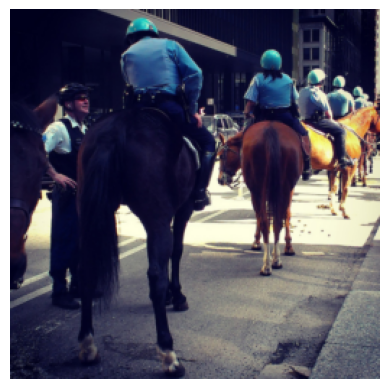

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

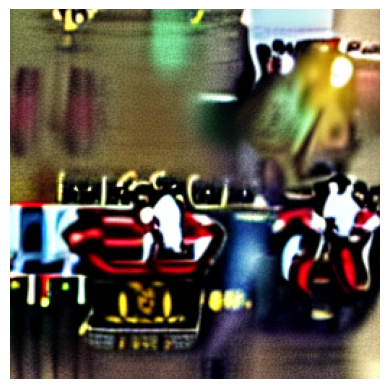

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

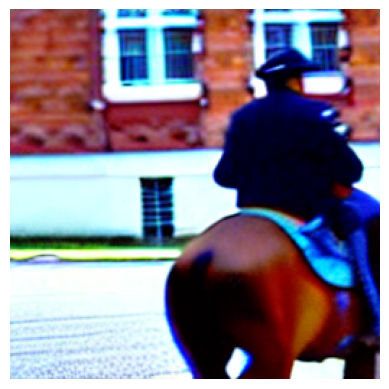

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.26806581020355225
End of batch processing.

Epoch 0, Batch Caption: a small bathroom with tile walls and a glass wall 


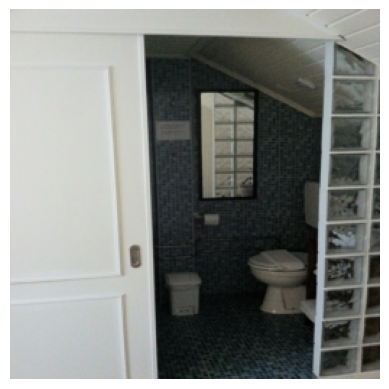

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

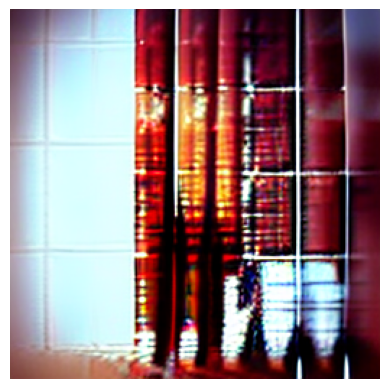

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

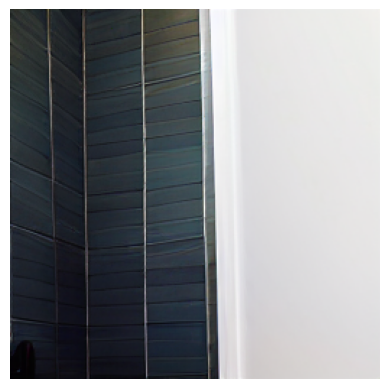

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.39213740825653076
End of batch processing.

Epoch 0, Batch Caption: A group of elderly people on a train platform. 


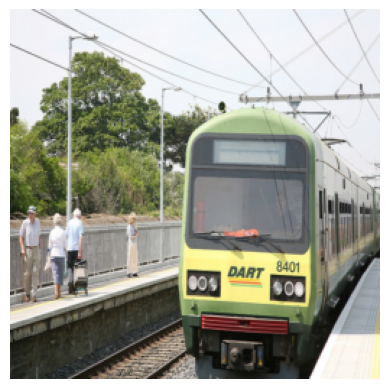

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

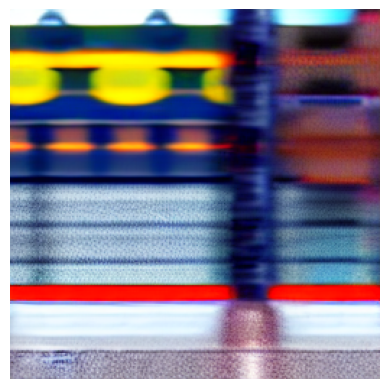

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

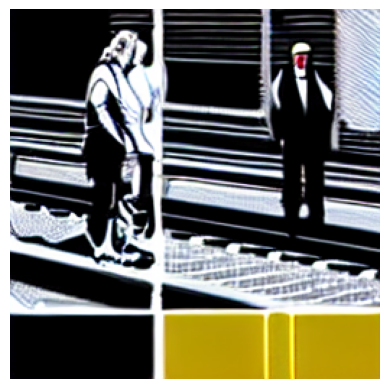

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.2583102285861969
End of batch processing.

Epoch 0, Batch Caption: A messy unmade bed with a pillow and a book on it.


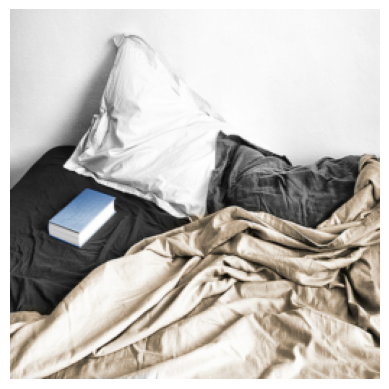

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

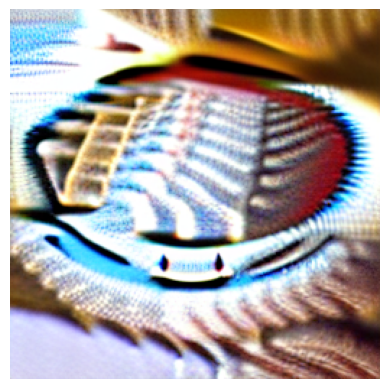

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

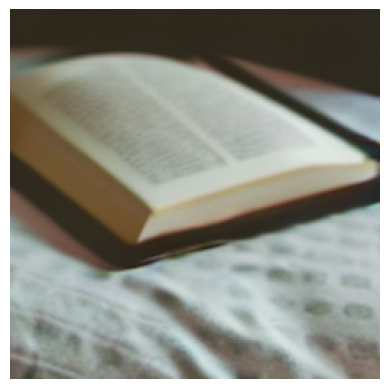

real pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator real Loss: tensor([0.], grad_fn=<ReluBackward0>)
student pred = (tensor([[1.]], grad_fn=<HardtanhBackward0>),)
Discriminator Fake Loss: tensor([2.], grad_fn=<ReluBackward0>)
Student Loss: tensor([-1.], grad_fn=<MulBackward0>)
Adversarial Loss: tensor([1.], grad_fn=<DivBackward0>)
Distillation Loss: 0.15437783300876617
End of batch processing.

Epoch 0, Batch Caption: A cat sleeps on a blanket while another cat peers out a window. 


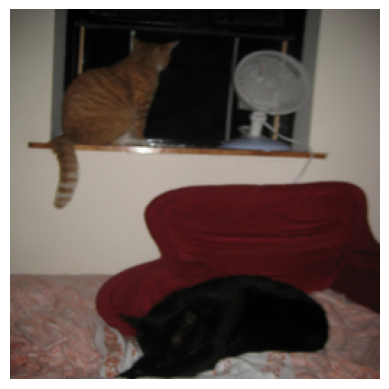

Performing forward diffusion...
Generating student image...


  0%|          | 0/4 [00:00<?, ?it/s]

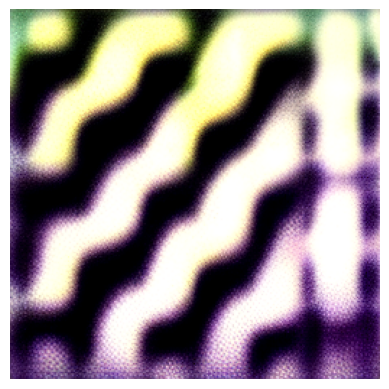

Forward diffusion on student image...
Generating teacher image...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
for epoch in range(100):
    for batch in train_dataset:

        image = url_to_tensor(batch["image"])
        caption = batch["caption"]

        # Creating labels for real and fake images
        valid = torch.ones(image.size(0), 1)
        fake = torch.zeros(image.size(0), 1)
        real_image = image

        # Displaying the base image and its caption
        print(f"Epoch {epoch}, Batch Caption: {caption}")
        show_tensor_image(real_image)

        # Forward diffusion step
        print("Performing forward diffusion...")
        diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Transforming images for distillation loss calculation
        transform = transforms.ToTensor()

        # Generating student image
        print("Generating student image...")
        student_image = student_model(caption, image=diffused_image, height=256, width=256, num_inference_steps=4).images[0]
        student_image_tensor = transform(student_image)
        show_tensor_image(student_image_tensor)

        # Forward diffusion on student image
        print("Forward diffusion on student image...")
        new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Generating teacher image
        print("Generating teacher image...")
        teacher_image = teacher_model(caption, image=new_diffused_image, height=256, width=256, num_inference_steps=100).images[0]
        teacher_image_tensor = transform(teacher_image)
        show_tensor_image(teacher_image_tensor)

        # Discriminator predictions and loss for real image
        real_pred = discriminator_processor(image, return_tensors="pt")


        real_pred = discriminator_model(**real_pred, return_dict=False)

        print(f"real pred = {real_pred}")


        discriminator_real_loss = adversarial_loss_function(real_pred[0][0], torch.tensor(1.))

        print(f"Discriminator real Loss: {discriminator_real_loss}")

        # Discriminator predictions and loss for student image
        student_pred = discriminator_processor(student_image, return_tensors="pt")
        student_pred = discriminator_model(**student_pred, return_dict=False)

        print(f"student pred = {student_pred}")

        discriminator_fake_loss = adversarial_loss_function(student_pred[0][0], torch.tensor(-1.))
        #student_loss = adversarial_loss_function(student_pred[0][0], torch.tensor(1.))
        student_loss = student_loss_function(student_pred[0][0], torch.tensor(1.))


        print(f"Discriminator Fake Loss: {discriminator_fake_loss}")
        print(f"Student Loss: {student_loss}")

        # Calculating adversarial loss
        adversarial_loss = (discriminator_real_loss + discriminator_fake_loss)/2
        print(f"Adversarial Loss: {adversarial_loss}")

        # Computing distillation loss
        distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
        distillation_loss.requires_grad = True
        print(f"Distillation Loss: {distillation_loss}")

        # Backpropagation for student model
        student_optimizer.zero_grad()
        student_loss.backward(retain_graph=True) # Retain graph because student model also needs to backpropagate in this iteration
        distillation_loss.backward()
        student_optimizer.step()

        # Backpropagation for discriminator model
        discriminator_model_optimizer.zero_grad()
        adversarial_loss.backward()
        discriminator_model_optimizer.step()

        print("End of batch processing.\n")
